In [1]:
%matplotlib widget
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
import sys, os
from scipy.optimize import curve_fit

sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation/')
sys.path.append('/Users/alexisdevitre/Documents/GitHub/2025-devitre-PhD/')
import hts_fitfunctions as ff
import default_style


In [16]:
palette = sns.color_palette('viridis', 6)

In [25]:
fname = 'ffj38-anneal.xlsx'
sheets = pd.ExcelFile(fname).sheet_names

#figure, axis = plt.subplots()

xx, yy = [], []
#fig.savefig('Ic_vs_annealtime/Ic_vs_annealtime_{}'.format(sheet))
i = 0
for sheet in sheets:
    data = pd.read_excel(fname, sheet_name=sheet, names=['fpath', 'temperature', 'ic', 'timeends', 'temperature_group', 'additional_anneal_time'])
    data = data.drop(columns=['fpath', 'timeends'])
    additional_anneal_time = data.additional_anneal_time.unique()
    for cumulated_time, additional_time in zip(additional_anneal_time.cumsum(), additional_anneal_time):
        data.loc[data['additional_anneal_time'] == additional_time, 'additional_anneal_time'] = cumulated_time
    data = data.rename(columns={"additional_anneal_time": "cumulated_anneal_time"})

    df = data.groupby(["cumulated_anneal_time", "temperature_group"]).agg(["mean", "std"]).reset_index()
    ic20k, ic20k_err = []
    for cumulated_time in df.cumulated_anneal_time.unique():
        subdf = df[df.cumulated_anneal_time == cumulated_time]
        
        x, xerr = subdf.temperature['mean'], subdf.temperature['std']
        y, yerr = subdf.ic['mean'], subdf.ic['std']

        fig, ax = plt.subplots()
        ax.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, marker='o')

        try:
            popt, pcov = curve_fit(ff.quadratic, x, y)
            xsmooth = np.linspace(20, np.max(x), 100)
            ysmooth = ff.quadratic(xsmooth, *popt)
            
        except TypeError as te:
            try:
                popt, pcov = curve_fit(ff.linear, x, y)
                xsmooth = np.linspace(20, np.max(x), 100)
                ysmooth = ff.linear(xsmooth, *popt)
            except TypeError as te:
                pass
        ax.plot(xsmooth, ysmooth, linewidth=4, alpha=.3)
        fig.savefig('IcT/{}_{:4.0f}'.format(sheet, cumulated_time))

        ic20k.append(ysmooth[0])
        
        plt.close(fig)
    
    if float(sheet.split('.')[0].split('anneal')[-1][:-1]) == 230:
        xx = df.cumulated_anneal_time.unique()
        yy = ic20k
        #axis.plot(df.cumulated_anneal_time.unique(), ic20k, marker='+', label=sheet, c=palette[i])
        #i+=1
#axis.legend()

    

/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_29541/3201254546.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(ff.linear, x, y)
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_29541/3201254546.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(ff.linear, x, y)
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_29541/3201254546.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(ff.linear, x, y)
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_29541/3201254546.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(ff.linear, x, y)


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/jl/4_5mv35x3wb9cccz5qcc6vmc0000gn/T/ipykernel_29541/2396191596.py:3: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathrm{I_c}$ [A]')


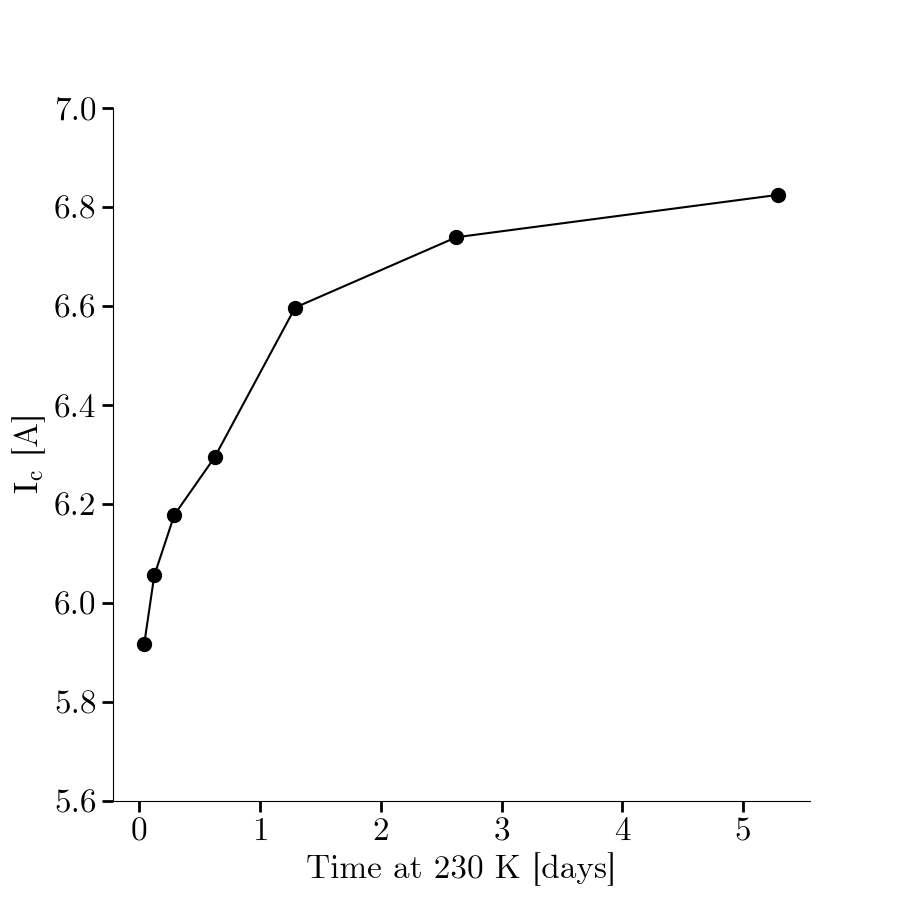

In [36]:
fig, ax = plt.subplots()
ax.plot(xx/(24), yy, marker='o', color='k')
ax.set_ylabel('$\mathrm{I_c}$ [A]')
ax.set_xlabel('Time at 230 K [days]')
ax.set_ylim(5.6, 7)
fig.savefig('loglinear.png', dpi=300, transparent=True)